In [1]:
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import visuals as vs
import category_encoders as ce
from datetime import date
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.feature_selection import SelectKBest
from lightgbm.sklearn import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
import scipy.sparse as sp
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error,make_scorer
from pdpbox import pdp, get_dataset, info_plots
from sklearn.pipeline import Pipeline
seed=11

/Users/dwightliu/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
def adj_r2_score(model, y, yhat):
        """Adjusted R square — put fitted linear model, y value, estimated y value in order
        """
        from sklearn import metrics
        adj = 1 - float(len(y)-1)/(len(y)-len(model.coef_)-1)*(1 - metrics.r2_score(y,yhat))
        return adj

In [3]:
def check_non_numeric_cols(df):
    non_num_cols = []
    logging.info("The following features are object:")
    for col in df:
        if str(df[col].dtype) not in ['float64','int64']:
            non_num_cols.append(col)
            logging.info(col+': '+str(str(df[col].dtype)))
    return non_num_cols

def check_null_cols(df):
    null_cols = []
    for col in df:
        if df[col].isnull().any():
            logging.warning(col+' has null value and data type: '+str(str(df[col].dtype)))
            null_cols.append(col)
    if len(null_cols) > 0:
        logging.warning('This data has null value and return the columns which has null value')
        return null_cols
    else:
        logging.info("The data has no null vale. Clean!")
        return None

def fill_missing(df,null_cols):
    if len(null_cols) > 0:
        logging.info("start to fill up missing value")
        for col in null_cols:
            if str(df[col].dtype).startswith(('float','int')):
                df[col].fillna(-1,inplace=True)
            else:
                df[col].fillna('missing',inplace=True)
        return df
    else:
        logging.info("no need to fill up. Clean!")
        return df

In [4]:
data = pd.read_csv('data/historical_data.csv')
test_data = pd.read_csv('data/predict_data.csv')

In [5]:
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [6]:
test_data.head()

,market_id,created_at,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_id,platform
0,3.0,2015-02-25 02:22:30,5477,NaN,1.0,5,7500,4,800,1800,4.0,4.0,4.0,446,670.0,194096,android
1,3.0,2015-02-25 01:14:19,5477,NaN,1.0,5,7100,4,800,1500,4.0,1.0,1.0,446,446.0,236895,other
2,4.0,2015-02-22 02:27:44,5477,thai,1.0,4,4500,2,750,1500,9.0,7.0,6.0,446,504.0,190868,android
3,3.0,2015-02-25 01:32:39,5477,NaN,1.0,1,1700,1,1400,1400,3.0,3.0,3.0,446,687.0,183076,ios
4,1.0,2015-02-24 05:20:45,2841,italian,1.0,2,3150,2,1525,1625,4.0,4.0,4.0,446,528.0,186200,android


In [ ]:
### EDA

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
market_id                                       196441 non-null float64
created_at                                      197428 non-null object
actual_delivery_time                            197421 non-null object
store_id                                        197428 non-null int64
store_primary_category                          192668 non-null object
order_protocol                                  196433 non-null float64
total_items                                     197428 non-null int64
subtotal                                        197428 non-null int64
num_distinct_items                              197428 non-null int64
min_item_price                                  197428 non-null int64
max_item_price                                  197428 non-null int64
total_onshift_dashers                           181166 non-null float64
total_busy_dashers                      

In [8]:
data.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
count,196441.000000,197428.000000,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000
mean,2.978706,3530.510272,2.882352,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,308.560179,545.358935
std,1.524867,2053.496711,1.503771,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830,90.139653,219.352902
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000
25%,2.000000,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000
50%,3.000000,3592.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000
75%,4.000000,5299.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000


In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54778 entries, 0 to 54777
Data columns (total 17 columns):
market_id                                       54528 non-null float64
created_at                                      54778 non-null object
store_id                                        54778 non-null int64
store_primary_category                          53435 non-null object
order_protocol                                  54495 non-null float64
total_items                                     54778 non-null int64
subtotal                                        54778 non-null int64
num_distinct_items                              54778 non-null int64
min_item_price                                  54778 non-null int64
max_item_price                                  54778 non-null int64
total_onshift_dashers                           50145 non-null float64
total_busy_dashers                              50145 non-null float64
total_outstanding_orders                        50145

In [10]:
test_data.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_id
count,54528.000000,54778.000000,54495.000000,54778.000000,54778.000000,54778.000000,54778.000000,54778.000000,50145.000000,50145.000000,50145.000000,54778.000000,54767.000000,54778.000000
mean,3.031360,3489.640969,2.885017,3.227737,2715.758772,2.691902,683.757384,1166.795356,49.076179,43.515206,62.566756,308.112673,547.765406,126118.103454
std,1.531606,2050.221801,1.512087,2.557472,1897.919808,1.650204,538.496995,574.594726,37.594714,34.051339,56.378953,88.937888,220.459715,72683.611935
min,1.000000,2.000000,1.000000,1.000000,0.000000,1.000000,-63.000000,0.000000,-1.000000,-4.000000,-9.000000,0.000000,0.000000,20.000000
25%,2.000000,1661.000000,1.000000,2.000000,1420.000000,2.000000,299.000000,819.000000,19.000000,16.000000,19.000000,251.000000,385.000000,62938.500000
50%,3.000000,3518.000000,3.000000,3.000000,2220.000000,2.000000,595.000000,1095.000000,41.000000,36.000000,45.000000,251.000000,544.000000,126194.000000
75%,4.000000,5247.000000,4.000000,4.000000,3415.000000,3.000000,929.000000,1399.000000,71.000000,63.000000,91.000000,446.000000,703.000000,188916.000000
max,6.000000,6986.000000,7.000000,81.000000,29925.000000,19.000000,25040.000000,25142.000000,175.000000,169.000000,292.000000,1095.000000,1550.000000,252031.000000


In [11]:
data[data['min_item_price'] <0]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
790,1.0,2015-01-29 02:59:28,2015-01-29 03:44:09,132,fast,4.0,3,1003,3,-86,1066,24.0,29.0,38.0,251,721.0
1351,2.0,2015-02-06 05:26:55,2015-02-06 06:15:41,6740,fast,4.0,35,1786,4,-1,488,33.0,36.0,52.0,251,587.0
46369,2.0,2015-02-08 23:20:59,2015-02-08 23:50:03,777,fast,4.0,25,1636,5,-35,514,81.0,61.0,72.0,251,469.0
46378,2.0,2015-02-08 06:02:12,2015-02-08 06:32:58,777,fast,4.0,15,1822,4,-48,433,36.0,36.0,43.0,251,339.0
77238,5.0,2015-02-14 22:01:48,2015-02-14 23:15:15,2276,pizza,3.0,1,3099,1,-31,52,22.0,26.0,34.0,251,377.0
91319,3.0,2015-02-15 20:46:57,2015-02-15 21:43:42,707,american,4.0,16,1601,5,-13,194,29.0,17.0,22.0,251,875.0
104173,3.0,2015-01-25 19:18:20,2015-01-25 20:37:08,1950,breakfast,3.0,7,6095,7,-30,1211,18.0,23.0,12.0,251,878.0
119785,1.0,2015-01-24 03:45:37,2015-01-24 04:42:59,2998,fast,4.0,10,1938,8,-9,594,28.0,40.0,46.0,251,551.0
119854,1.0,2015-02-10 03:31:22,2015-02-10 04:02:08,2054,italian,5.0,5,2585,3,-7,1235,49.0,47.0,59.0,251,333.0
165821,2.0,2015-02-02 20:24:15,2015-02-02 20:55:06,86,fast,4.0,18,1646,3,-6,297,49.0,41.0,37.0,251,638.0


In [12]:
data[data['total_onshift_dashers'] <0]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
6034,3.0,2015-02-14 01:48:58,2015-02-14 03:00:13,90,american,1.0,2,3538,2,1238,1606,-2.0,2.0,10.0,446,266.0
12888,3.0,2015-01-21 21:02:32,2015-01-21 21:41:03,2649,catering,2.0,1,986,1,892,827,-2.0,5.0,1.0,251,787.0
26395,3.0,2015-02-08 18:28:15,2015-02-08 19:17:31,2772,fast,3.0,2,1327,1,680,615,-1.0,6.0,6.0,251,368.0
30897,3.0,2015-02-07 19:55:46,2015-02-07 20:46:27,793,hawaiian,1.0,1,1202,1,987,1092,-1.0,9.0,5.0,446,773.0
33154,1.0,2015-02-02 22:27:36,2015-02-03 00:08:43,1337,american,1.0,2,2831,2,681,635,-1.0,13.0,16.0,446,394.0
53702,1.0,2015-01-25 02:55:01,2015-01-25 03:41:37,1238,chinese,1.0,2,1803,2,818,1061,-1.0,4.0,7.0,446,381.0
60282,1.0,2015-01-29 02:07:49,2015-01-29 02:48:26,4402,salad,5.0,2,1117,2,339,956,-3.0,0.0,16.0,251,187.0
61131,1.0,2015-02-01 03:42:22,2015-02-01 04:34:18,6379,sushi,5.0,7,2666,7,379,437,-2.0,8.0,5.0,251,486.0
118311,1.0,2015-02-09 03:35:22,2015-02-09 04:36:05,2194,japanese,3.0,2,1862,2,488,1162,-2.0,3.0,3.0,251,603.0
119242,3.0,2015-02-14 04:21:45,2015-02-14 05:40:08,4671,seafood,4.0,4,1874,3,110,1378,-2.0,-1.0,11.0,446,971.0


In [13]:
test_data[test_data['min_item_price'] <0]

,market_id,created_at,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_id,platform
13083,4.0,2015-02-23 01:02:19,5460,fast,4.0,10,1009,3,-6,212,77.0,60.0,59.0,251,696.0,248483,android
25009,6.0,2015-02-21 03:36:35,5045,mexican,3.0,11,3622,10,-30,1450,NaN,NaN,NaN,251,891.0,14861,ios
25022,6.0,2015-02-19 02:46:26,5045,mexican,3.0,4,1291,4,-63,881,NaN,NaN,NaN,251,892.0,12972,android
51572,1.0,2015-02-19 23:44:38,1119,chinese,2.0,2,1402,2,-8,1235,18.0,15.0,26.0,251,455.0,71867,ios


In [14]:
test_data[test_data['min_item_price'] <0].shape

(4, 17)

In [15]:
# if we don't know actual_delivery_time, we cannot use it for training
data = data.dropna(subset=['actual_delivery_time'])

In [16]:
set(data.columns) - set(test_data.columns)

{'actual_delivery_time'}

In [17]:
set(test_data.columns) - set(data.columns)

{'delivery_id', 'platform'}

In [18]:
data['created_at'] = pd.to_datetime(data['created_at'], format = '%Y-%m-%d %H:%M:%S', errors='coerce')
test_data['created_at'] = pd.to_datetime(test_data['created_at'], format = '%Y-%m-%d %H:%M:%S', errors='coerce')
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'], format = '%Y-%m-%d %H:%M:%S', errors='coerce')

In [19]:
# create target variable
data['target'] = (data['actual_delivery_time'] - data['created_at']).dt.total_seconds()

In [20]:
data[['target']].describe()

,target
count,1.974210e+05
mean,2.908257e+03
std,1.922961e+04
min,1.010000e+02
25%,2.104000e+03
50%,2.660000e+03
75%,3.381000e+03
max,8.516859e+06


In [21]:
print('median: ',data['target'].median())
print('mean: ',data['target'].mean())
print('mode: ',data['target'].mode())
print('positive skew')

median:  2660.0
mean:  2908.25737383561
mode:  0    2483.0
dtype: float64
positive skew


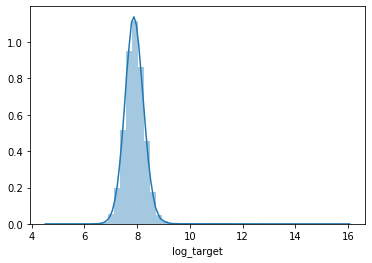

In [22]:
# becaasue the target must be always non negative and it's also positive skewed
# therefore I appplied with log transform
data['log_target'] = np.log(data['target'])
sns.distplot(data['log_target'])

lower bound:  17.214536433312002
upper bound:  114.78709719088786


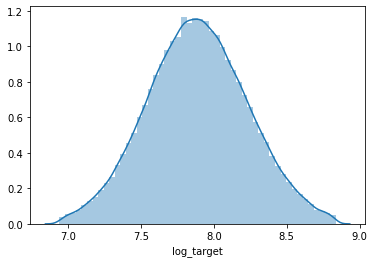

In [23]:
# Applied with IQR
Q1 = data['log_target'].quantile(0.25)
Q3 = data['log_target'].quantile(0.75)
IQR = Q3 - Q1
data = data[~ ( (data['log_target'] < (Q1 - 1.5 * IQR)) | (data['log_target'] > (Q3 + 1.5 * IQR)))]
print('lower bound: ',np.exp(Q1 - 1.5 * IQR)/60)
print('upper bound: ',np.exp(Q3 + 1.5 * IQR)/60)
sns.distplot(data['log_target'])

In [24]:
print(data['created_at'].min())
print(data['created_at'].max())

2015-01-21 15:22:03
2015-02-18 06:00:44


In [25]:
print(test_data['created_at'].min())
print(test_data['created_at'].max())

2015-02-18 14:50:28
2015-02-25 05:59:49


In [26]:
### seasonality check 
data['created_at_date'] = data['created_at'].dt.date
created_cnt = data.groupby('created_at_date')['store_id'].count().reset_index().sort_values(by='created_at_date')

In [27]:
created_cnt 

,created_at_date,store_id
0,2015-01-21,2062
1,2015-01-22,5943
2,2015-01-23,6573
3,2015-01-24,8175
4,2015-01-25,7858
5,2015-01-26,5407
6,2015-01-27,5459
7,2015-01-28,5614
8,2015-01-29,5985
9,2015-01-30,6694


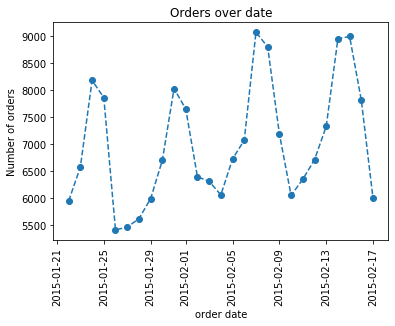

In [28]:
# remove 2014-10-19	 data
created_cnt = created_cnt[(created_cnt['created_at_date'] > date(2015,1,21)) & (created_cnt['created_at_date'] < date(2015,2,18))]
plt.plot(created_cnt['created_at_date'],created_cnt['store_id'],'o--')
plt.title('Orders over date')
plt.xlabel('order date')
plt.ylabel('Number of orders')
plt.xticks(rotation=90)
data = data[data['created_at'].dt.date > date(2014,12,31)]

In [29]:
print('Cardinality Check')
print('store_id: ',data['store_id'].nunique())
print('store_primary_category: ', data['store_primary_category'].nunique())
print('order_protocol: ', data['order_protocol'].nunique())

Cardinality Check
store_id:  6732
store_primary_category:  74
order_protocol:  7


### feature engineering

In [30]:
data['day_of_week'] = data['created_at'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)
data['hours'] = data['created_at'].dt.hour
data['is_holiday'] = np.where(data['created_at'].dt.date == date(2015,2,16),1,0)

In [59]:
# impute missing
#data['total_three_columns_missing'] = np.where(data['total_outstanding_orders'].isnull(), 1, 0)
'''
data['total_onshift_dashers'] = data['total_onshift_dashers'].fillna(data['total_onshift_dashers'].median())
data['total_busy_dashers'] = data['total_busy_dashers'].fillna(data['total_busy_dashers'].median())
data['total_outstanding_orders'] = data['total_outstanding_orders'].fillna(data['total_outstanding_orders'].median())
'''
#data['total_onshift_dashers'] = data['total_onshift_dashers'].fillna(-1)
#data['total_busy_dashers'] = data['total_busy_dashers'].fillna(-1)
#data['total_outstanding_orders'] = data['total_outstanding_orders'].fillna(-1)

# franchise check
store_lst = data.groupby('store_id')[['market_id']].nunique().reset_index()
franchise_lst = list(store_lst[store_lst['market_id'] > 1]['store_id'].values)
data['is_franchise'] = np.where(data['store_id'].isin(franchise_lst), 1, 0)
# ratio 
data['dasher_busy_ratio'] = data['total_busy_dashers']/data['total_onshift_dashers']
data['order_dasher_ratio'] = data['total_outstanding_orders']/data['total_onshift_dashers']

In [60]:
# numerical
num_cols = ['total_items', 'subtotal',
'num_distinct_items', 'min_item_price', 'max_item_price',
'total_onshift_dashers', 'total_busy_dashers',
'total_outstanding_orders', 'estimated_order_place_duration',
'estimated_store_to_consumer_driving_duration',
# feature engineering
'day_of_week', 'is_weekend', 'hours','is_holiday',
'is_franchise', #'total_three_columns_missing',
'dasher_busy_ratio', 'order_dasher_ratio']
# categorical
one_hot_cat_cols = ['market_id','order_protocol']
bin_cat_cols = ['store_id','store_primary_category']
cat_cols = bin_cat_cols + one_hot_cat_cols

In [61]:
df = data[num_cols+cat_cols+['log_target']].copy()

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195139 entries, 0 to 197427
Data columns (total 22 columns):
total_items                                     195139 non-null int64
subtotal                                        195139 non-null int64
num_distinct_items                              195139 non-null int64
min_item_price                                  195139 non-null int64
max_item_price                                  195139 non-null int64
total_onshift_dashers                           195139 non-null float64
total_busy_dashers                              195139 non-null float64
total_outstanding_orders                        195139 non-null float64
estimated_order_place_duration                  195139 non-null int64
estimated_store_to_consumer_driving_duration    194616 non-null float64
day_of_week                                     195139 non-null int64
is_weekend                                      195139 non-null int64
hours                                    

In [ ]:
null_cols = check_null_cols(df)
df = fill_missing(df,null_cols)

In [35]:
def custom_asymmetric_objective(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual<0, -2*residual, -2*2*residual)
    hess = np.where(residual<0, 2, 2.0*2)
    return grad, hess

def custom_asymmetric_eval(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, residual**2, (residual**2)*2.0) 
    return "custom_asymmetric_eval", np.mean(loss), False
# Create custom metric
def custom_metric(y_test, y_pred):
    # Calculate r-squared score
    i = 0
    res = 0
    for tf in y_test > y_pred:
        if tf:
            res += 2*((y_test.values[i] - y_pred[i])**2)
        else:
            res += ((y_test.values[i] - y_pred[i])**2)
        i += 1

    # Return r-squared score
    return -res/i
cus_scorer = make_scorer(custom_metric)

In [63]:
X = df.drop('log_target',axis=1)
y = df['log_target']

In [37]:
bin_encoder = ce.BinaryEncoder(cols=bin_cat_cols)
hot_encoder = ce.OneHotEncoder(cols=one_hot_cat_cols)
lgbm = LGBMRegressor(random_state=seed, objective=custom_asymmetric_objective)
pipe = Pipeline(steps=[('bin_encoder', bin_encoder), ('hot_encoder', hot_encoder), ('lgbm', lgbm)])
param_grid = {
    'lgbm__num_leaves':[30, 50, 70], 
    'lgbm__max_depth':[10, 20, 30, 40],
    'lgbm__min_child_samples': [5 ,10, 20, 30, 40]
}
search = GridSearchCV(pipe, param_grid, 
                      scoring=cus_scorer,
                            n_jobs=-1,
                            iid=False, 
                            verbose=1,
                            cv=5)
search.fit(X, y,lgbm__eval_metric=custom_asymmetric_eval)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [64]:
bin_encoder = ce.BinaryEncoder(cols=bin_cat_cols)
bin_encoder.fit(X)
X = bin_encoder.transform(X)
hot_encoder = ce.OneHotEncoder(cols=one_hot_cat_cols)
hot_encoder.fit(X)
X_t = hot_encoder.transform(X)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.2, random_state=seed)

In [66]:
lgbm = LGBMRegressor(random_state=seed, num_leaves=20, min_child_samples=40, max_depth=20,objective=custom_asymmetric_objective)
lgbm.fit(X_train, y_train, eval_metric=custom_asymmetric_eval)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=20,
              min_child_samples=40, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=20,
              objective=<function custom_asymmetric_objective at 0x1a26c30b00>,
              random_state=11, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [67]:
y_pred = lgbm.predict(X_test)
y_train_pred = lgbm.predict(X_train)

In [68]:
number_sample_train, feature_dim_train = X_train.shape
number_sample_test, feature_dim_test = X_test.shape
print('R_quared: ',r2_score(y_test,y_pred))
test_adj = 1 - float(number_sample_test-1)/(number_sample_test-feature_dim_test-1)*(1 - r2_score(y_test,y_pred))
print('adjusted_R_quared: ',test_adj)
print('mean quared error: ',mean_squared_error(y_test,y_pred))
print('mean quared error: ',-custom_metric(y_test,y_pred))
print('mean quared error: ',mean_squared_error(np.exp(y_test),np.exp(y_pred)))
print('mean quared error: ',custom_asymmetric_eval(y_test,y_pred)[1])

R_quared:  0.32224074263437674
adjusted_R_quared:  0.3213016566030795
mean quared error:  0.08033082773255426
mean quared error:  0.10562662163413443
mean quared error:  652687.3929193004
mean quared error:  0.10562662163413471


In [46]:
print('R_quared: ',r2_score(y_train,y_train_pred))
test_adj = 1 - float(number_sample_test-1)/(number_sample_test-feature_dim_test-1)*(1 - r2_score(y_train,y_train_pred))
print('adjusted_R_quared: ',test_adj)
print('mean quared error: ',mean_squared_error(y_train,y_train_pred))
print('mean quared error: ',-custom_metric(y_train,y_train_pred))
print('mean quared error: ',mean_squared_error(np.exp(y_train),np.exp(y_train_pred)))
print('mean quared error: ',custom_asymmetric_eval(y_train,y_train_pred)[1])

R_quared:  0.33248448340935977
adjusted_R_quared:  0.3315595908453822
mean quared error:  0.07867420751493609
mean quared error:  0.10357714688277904
mean quared error:  643948.038922748
mean quared error:  0.10357714688277794


In [ ]:
custom_metric(y_train,y_train_pred)

In [ ]:
y_test.shape[0]

In [ ]:
test_adj_lst = []
train_adj_lst = []
mse_test_lst = []
mse_train_lst = []
num_leaves_lst = np.arange(3,20,1)
for num_leave in range(3,20,1):
    lgbm = LGBMRegressor(random_state=seed, num_leaves=num_leave,n_estimators=800, max_depth=5)
    lgbm.fit(X_train, y_train)
    y_train_pred = lgbm.predict(X_train)
    y_pred = lgbm.predict(X_test)
    test_adj_lst.append( 1 - float(number_sample_test-1)/(number_sample_test-feature_dim_test-1)*(1 - r2_score(y_test,y_pred)) )
    train_adj_lst.append( 1 - float(number_sample_train-1)/(number_sample_train-feature_dim_train-1)*(1 - r2_score(y_train,y_train_pred)) )
    mse_test_lst.append( custom_metric(np.exp(y_test),np.exp(y_pred)) )
    mse_train_lst.append( custom_metric(np.exp(y_train),np.exp(y_train_pred)) )

In [ ]:
plt.figure(figsize=(7, 5))
plt.title('LGBM Regressor Complexity Performance')
plt.plot(num_leaves_lst, train_adj_lst, 'o-', color = 'r', label = 'Training Score')
plt.plot(num_leaves_lst, test_adj_lst, 'o-', color = 'g', label = 'Validation Score')
plt.ylim(0.325, 0.45)

In [ ]:
plt.figure(figsize=(7, 5))
plt.title('LGBM Regressor Complexity Performance')
plt.plot(num_leaves_lst, mse_train_lst, 'o-', color = 'r', label = 'Training Score')
plt.plot(num_leaves_lst, mse_test_lst, 'o-', color = 'g', label = 'Validation Score')

In [ ]:
mse_train_lst

In [ ]:
test_adj_lst = []
train_adj_lst = []
mse_test_lst = []
mse_train_lst = []
min_child_samples_lst = np.arange(500,5500,500)
for sample in range(500,5500,500):
    lgbm = LGBMRegressor(random_state=seed, num_leaves=10,n_estimators=800, max_depth=5, min_child_samples=sample)
    lgbm.fit(X_train, y_train)
    y_train_pred = lgbm.predict(X_train)
    y_pred = lgbm.predict(X_test)
    test_adj_lst.append( 1 - float(number_sample_test-1)/(number_sample_test-feature_dim_test-1)*(1 - r2_score(y_test,y_pred)) )
    train_adj_lst.append( 1 - float(number_sample_train-1)/(number_sample_train-feature_dim_train-1)*(1 - r2_score(y_train,y_train_pred)) )
    mse_test_lst.append( custom_metric(y_test,y_pred) )
    mse_train_lst.append( custom_metric(y_train,y_train_pred) )

In [ ]:
plt.figure(figsize=(7, 5))
plt.title('LGBM Regressor Complexity Performance')
plt.plot(min_child_samples_lst, mse_train_lst, 'o-', color = 'r', label = 'Training Score')
plt.plot(min_child_samples_lst, mse_test_lst, 'o-', color = 'g', label = 'Validation Score')

In [ ]:
#whole_feature_cols = np.array(num_cols + list(enc.get_feature_names()))
#selected_feature_cols = np.array(num_cols + list(enc.get_feature_names(['market_id', 'order_protocol'])))
selected_feature_cols = np.array(hot_encoder.get_feature_names())
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_, selected_feature_cols)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(25))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [ ]:
feature_imp

In [ ]:
feature_imp[feature_imp['Value'] == 0]

In [ ]:
feature_imp.sort_values(by="Value",ascending=False).head()

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df=data[data['total_outstanding_orders'] >= 0], feature='total_outstanding_orders', feature_name='total_outstanding_orders', target='target', show_percentile=True
)

In [ ]:
data[(data['total_outstanding_orders'] < 0) & (data['total_three_columns_missing'] == 0)]['target'].mean()

In [ ]:
data[data['total_three_columns_missing'] == 1]['target'].mean()

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df=data[data['total_onshift_dashers'] >=0], feature='total_onshift_dashers', feature_name='total_onshift_dashers', target='target', show_percentile=True
)

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df=data, feature='hours', feature_name='hours', target='target', show_percentile=True
)

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df=data.dropna(subset=['estimated_store_to_consumer_driving_duration']), feature='estimated_store_to_consumer_driving_duration', feature_name='estimated_store_to_consumer_driving_duration', target='target'
)